In [1]:
# Imports
import numpy as np
import pandas as pd
import sklearn.metrics as skm
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.tsa.vector_ar.vecm
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
import openpyxl

In [2]:
# Define your path
path = "/Users/v.d Bosch/Documents/Github/GVAR_modelling/"

# Loading data

In [3]:
country_list = openpyxl.load_workbook(path + "Country_data.xlsx").sheetnames
df_country = pd.read_excel(path + "Country_data.xlsx",index_col=0, sheet_name=country_list)
country_list = np.array(country_list)

dom_variable_list = np.array(['y','Dp','eq','ep','r','lr'])
for_variable_list = np.array(['ys','Dps','eqs','eps','rs','lrs'])
variable_list = np.array(['y','Dp','eq','ep','r','lr','ys','Dps','eqs','eps','rs','lrs'])
ext_variable_list = np.array(['Real gross domestic product','Inflation rate','Nominal equity price index','Real exchange rate','Short-term interest rate','Long-term interest rate'])

df_dom = {}
df_for = {}

set_variables = pd.DataFrame(index=variable_list)

for country in country_list:
    df_country[country].index = pd.date_range('1979-04','2020', freq='Q')

    domestic_cols = [col for col in df_country[country].columns if not col.endswith("s")]
    df_dom[country] = df_country[country].loc[:,domestic_cols]
    
    foreign_cols = [col for col in df_country[country].columns if col.endswith("s")]
    df_for[country] = df_country[country].loc[:,foreign_cols]
    
    for variable in variable_list:
        if np.isin(variable, df_country[country].columns):
            set_variables.loc[variable,country] = True
        else:
            set_variables.loc[variable,country] = False

In [4]:
year_list = ['2014','2015','2016']
df_trade = pd.read_excel(path + "Trading_data.xlsx",index_col=0, sheet_name=year_list)

df_weights = (df_trade['2014'] + df_trade['2015'] + df_trade['2016'])/3
df_weights.fillna(0, inplace=True)
    
for country in country_list:
    df_weights.loc[country] = df_weights.loc[country] / (df_weights.loc[country].sum())

In [5]:
continent_list = ["North America","South America","Europe","Africa","Asia","Oceania"]
df_continent = pd.read_excel(path + "Continent_weights.xlsx",index_col=0, sheet_name=continent_list)

In [6]:
set_variables

,Argentina,Australia,Austria,Belgium,Brazil,Canada,China,Chile,Finland,France,...,South Africa,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,Thailand,Turkey,United Kingdom,United States
y,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Dp,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
eq,True,True,True,True,False,True,False,True,True,True,...,True,False,True,True,True,True,True,False,True,True
ep,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
r,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,True,True,True,True,True
lr,False,True,True,True,False,True,False,False,False,True,...,True,False,False,True,True,True,False,False,True,True
ys,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
Dps,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
eqs,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
eps,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [7]:
# Potentially save this trade matrix
# df_weights.to_excel(path + "saved_values.xlsx")

# Show the chosen trade matrix
df_weights

,Argentina,Australia,Austria,Belgium,Brazil,Canada,China,Chile,Finland,France,...,South Africa,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,Thailand,Turkey,United Kingdom,United States
Argentina,0.000000,0.008665,0.002063,0.007553,0.265504,0.019327,0.167736,0.034908,0.002260,0.019450,...,0.009254,0.008480,0.002860,0.027472,0.003595,0.016839,0.015505,0.006432,0.014731,0.127333
Australia,0.002311,0.000000,0.003191,0.006511,0.003865,0.008153,0.316774,0.002678,0.001977,0.013372,...,0.004478,0.005235,0.038743,0.007230,0.005583,0.009138,0.041637,0.003134,0.026847,0.096530
Austria,0.001077,0.004666,0.000000,0.023828,0.003943,0.006292,0.039477,0.001176,0.004669,0.046809,...,0.003370,0.004741,0.002215,0.020448,0.013495,0.076398,0.003128,0.013682,0.032727,0.056016
Belgium,0.001380,0.004665,0.009805,0.000000,0.009555,0.008159,0.037591,0.001911,0.007168,0.155654,...,0.006535,0.006234,0.011449,0.027966,0.021245,0.016505,0.004056,0.014505,0.083659,0.083658
Brazil,0.083325,0.004864,0.003656,0.016222,0.000000,0.015844,0.228286,0.026367,0.003118,0.024419,...,0.006013,0.016003,0.011189,0.021386,0.005999,0.014832,0.011925,0.006638,0.020398,0.182179
Canada,0.002178,0.003611,0.002098,0.005405,0.005994,0.000000,0.085512,0.002731,0.001779,0.009769,...,0.001506,0.003504,0.002454,0.003732,0.002460,0.005817,0.003997,0.002522,0.025182,0.688913
Chile,0.005259,0.045174,0.003025,0.009534,0.029807,0.019124,0.000000,0.012846,0.002974,0.020563,...,0.016752,0.021652,0.030529,0.010953,0.005268,0.013094,0.029636,0.008466,0.030890,0.214996
China,0.031073,0.007480,0.002896,0.010668,0.077263,0.018019,0.283972,0.000000,0.003968,0.026821,...,0.001712,0.001863,0.001324,0.024979,0.004681,0.008171,0.009313,0.005000,0.011791,0.180274
Finland,0.001977,0.006114,0.013680,0.043957,0.009925,0.011597,0.056813,0.004494,0.000000,0.043882,...,0.005830,0.004492,0.003190,0.024368,0.184213,0.014717,0.003754,0.012743,0.057408,0.065657
France,0.001874,0.004305,0.012510,0.114731,0.009202,0.007205,0.056643,0.002033,0.004769,0.000000,...,0.003320,0.012125,0.009685,0.088556,0.014867,0.039569,0.004289,0.016234,0.070185,0.077206


# Plot variables

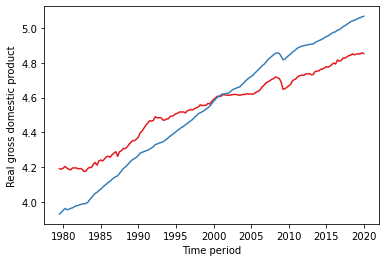

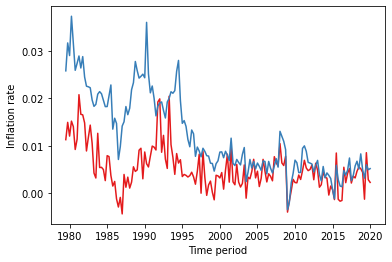

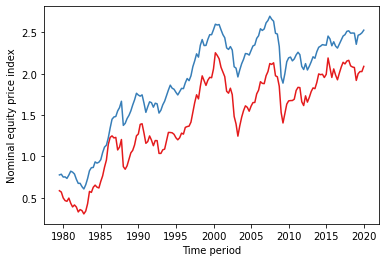

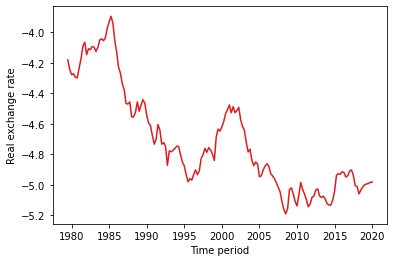

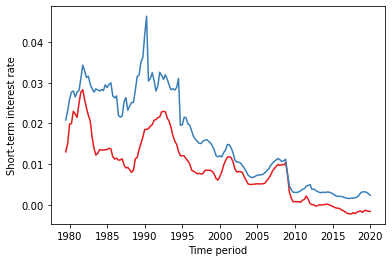

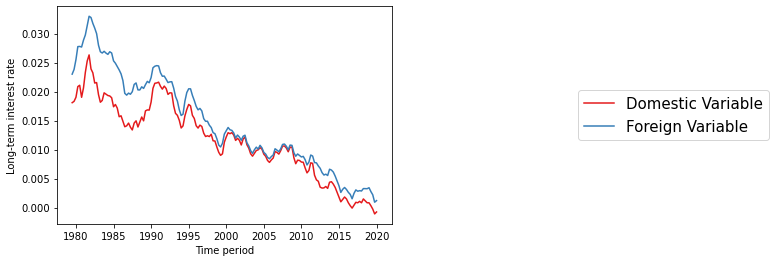

In [8]:
# Define a country
country = 'Germany'

sns.set_palette("Set1")

# Plot x_it and x_star for every variable
for i in range(len(ext_variable_list)-1):
    if set_variables[country][variable_list[i]]:
        plt.plot(df_dom[country][variable_list[i]])
    
    if set_variables[country][variable_list[i]+"s"]:
        plt.plot(df_for[country][variable_list[i]+"s"])
    
    plt.xlabel("Time period")
    plt.ylabel(ext_variable_list[i])
        
    plt.show()


fig, ax = plt.subplots()

sns.lineplot(data=df_dom[country][variable_list[5]],label='Domestic Variable')
sns.lineplot(data=df_for[country][variable_list[5]+"s"],label='Foreign Variable')
    
plt.xlabel("Time period")
plt.ylabel(ext_variable_list[5])
    
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(2.15, 0.5),prop={'size':15})

plt.show()

# Test order of integration

In [9]:
# Define the DataFrames to fill the results in
adf_test_diff0 = pd.DataFrame(index=dom_variable_list)
adf_test_diff1 = pd.DataFrame(index=dom_variable_list)
adf_test_diff2 = pd.DataFrame(index=dom_variable_list)

# Loop over every country and variable
for country in country_list:
    for variable in dom_variable_list:
        if set_variables[country][variable]:
            # Take the data and its first and second difference
            non_dif = df_dom[country][variable]
            first_dif = np.diff(non_dif)
            second_dif = np.diff(first_dif)
        
            # Fill the DataFrames with the adf test statistics
            adf_test_diff0.loc[variable,country] = round(sm.tsa.stattools.adfuller(non_dif, autolag= 'AIC',regression='ct')[1],4)
            adf_test_diff1.loc[variable,country] = round(sm.tsa.stattools.adfuller(first_dif, autolag= 'AIC',regression='ct')[1],4)
            adf_test_diff2.loc[variable,country] = round(sm.tsa.stattools.adfuller(second_dif, autolag= 'AIC',regression='ct')[1],4)

In [10]:
# Potentially save these unit root test results
# adf_test_diff0.to_excel(path + "saved_values.xlsx")

# Show the results
# adf_test_diff0
# adf_test_diff1
# adf_test_diff2

# Useful other variables

In [11]:
dom_variables = np.array([])

for country in country_list:
    for variable in dom_variable_list:
        if set_variables[country][variable]:
            dom_variables = np.append(dom_variables,[str(variable)+"_"+str(country)])

for_variables = np.array([])

for country in country_list:
    for variable in for_variable_list:
        if set_variables[country][variable]:
            for_variables = np.append(for_variables,[str(variable)+"_"+str(country)])

k_i = {}
k_star = {}
k = 0

for country in country_list:
    k_i[country] = set_variables[country][dom_variable_list].sum()
    k_star[country] = set_variables[country][for_variable_list].sum()
    k += k_i[country]

# Determine lag order

In [12]:
max_lag = 4

for country in country_list:
    # Define the current lowest BIC value
    min_bic = 1000000
    
    # Loop over all possible combinations
    for lag_x_it in range(1,max_lag+1):
        for lag_x_star in range(1,max_lag+1):
    
            max_lag = max(lag_x_it,lag_x_star)
    
            x_it_star = pd.concat([df_dom[country],df_for[country]],axis=1)
    
            coin_rank = statsmodels.tsa.vector_ar.vecm.coint_johansen(x_it_star,det_order=-1,k_ar_diff=max_lag-1)

            rank = 0
            while (rank < k_i[country] and coin_rank.lr2[rank] > coin_rank.cvm[:,1][rank]):
                rank += 1

            coin_result = statsmodels.tsa.vector_ar.vecm.VECM(endog= df_dom[country][1:],exog=df_for[country].diff(1)[1:],exog_coint=df_for[country][1:],coint_rank=rank,k_ar_diff=max_lag-1).fit()
    
            # Initialize a dataframe with the x_star values of lag 0
            df_parameters = pd.concat([df_dom[country].shift(1),df_for[country].shift(1)], axis=1) @ np.vstack([coin_result.beta,coin_result.det_coef_coint])
            df_parameters.columns = ["_" + str(i) +"_coin" for i in range(coin_result.beta.shape[1])]

            # Initialize a dataframe with the x_star values of lag 0
            lagged_x_star = pd.concat([df_for[country]],axis=1)
            lagged_x_star.columns += "_L0"
            df_parameters = pd.concat([df_parameters,lagged_x_star],axis=1)
            
            # Loop over all lag_x_it values to add the lagged values of x_it to df_parameters
            for lag in range(1,lag_x_it+1):
                if (lag <= lag_x_it-1):
                    lagged_x_it = df_dom[country].diff(1).shift(lag)
                    lagged_x_it.columns += "_dom_diff_L"+str(lag) 
                    df_parameters = pd.concat([df_parameters,lagged_x_it], axis=1)
            
            # Loop over all lag_x_star values to add the lagged values of x_star to df_parameters
            for lag in range(1,lag_x_star+1):
                if (lag <= lag_x_star-1):
                    lagged_x_star = df_for[country].shift(lag)
                    lagged_x_star.columns += "_for_diff_L"+str(lag) 
                    df_parameters = pd.concat([df_parameters,lagged_x_star], axis=1)
        
            # Create and fit the model
            model = VAR(endog = df_dom[country].diff(1).iloc[max_lag:], exog = df_parameters.iloc[max_lag:])
            results = model.fit(maxlags=0,trend='ct',method='ols')
            
#             print("x_it_lag "+str(lag_x_it)+"     x_star_lag "+str(lag_x_star))
#             print(np.log(results.llf))
            # Update the lag and BIC value if the BIC value is smaller
            if (results.bic < min_bic):
                min_bic = results.bic
                best_lag_bic = (lag_x_it,lag_x_star)
            
    print("For",country)
    print("The lag order by BIC is",best_lag_bic)
    print("The BIC value is",min_bic)
    print("")
            

For Argentina
The lag order by BIC is (2, 1)
The BIC value is -23.401279744577266

For Australia
The lag order by BIC is (1, 2)
The BIC value is -57.42292976366838

For Austria
The lag order by BIC is (1, 2)
The BIC value is -60.48238482135193

For Belgium
The lag order by BIC is (1, 2)
The BIC value is -60.63390087591646

For Brazil
The lag order by BIC is (2, 3)
The BIC value is -23.329975195738957

For Canada
The lag order by BIC is (1, 2)
The BIC value is -62.13827412284488

For China
The lag order by BIC is (1, 1)
The BIC value is -38.07907199524072

For Chile
The lag order by BIC is (1, 1)
The BIC value is -35.999005058937584

For Finland
The lag order by BIC is (1, 2)
The BIC value is -43.13584127946569

For France
The lag order by BIC is (1, 2)
The BIC value is -62.46716211994746

For Germany
The lag order by BIC is (1, 2)
The BIC value is -62.13876131874755

For India
The lag order by BIC is (1, 1)
The BIC value is -39.84449742155267

For Indonesia
The lag order by BIC is (3, 

# Determining the cointegrating relationships

In [13]:
for country in country_list:
    # Define the chosen lag
    lag_x_it = 2
    lag_x_star = 1
    max_lag = max(lag_x_it,lag_x_star)
    
    x_it_star = pd.concat([df_dom[country],df_for[country]],axis=1)
    
    eigenvalues = statsmodels.tsa.vector_ar.vecm.coint_johansen(x_it_star,det_order=-1,k_ar_diff=max_lag-1).eig

    # Determine the rank of cointegration
    rank = np.sum(np.cumsum(eigenvalues) < 1)

    if (rank > 5):
        rank = 5
        
    print("For",country)
    print("The amount of cointegrating relationships is",rank)
    print("")
            

For Argentina
The amount of cointegrating relationships is 2

For Australia
The amount of cointegrating relationships is 2

For Austria
The amount of cointegrating relationships is 2

For Belgium
The amount of cointegrating relationships is 2

For Brazil
The amount of cointegrating relationships is 2

For Canada
The amount of cointegrating relationships is 2

For China
The amount of cointegrating relationships is 2

For Chile
The amount of cointegrating relationships is 2

For Finland
The amount of cointegrating relationships is 2

For France
The amount of cointegrating relationships is 2

For Germany
The amount of cointegrating relationships is 2

For India
The amount of cointegrating relationships is 2

For Indonesia
The amount of cointegrating relationships is 2

For Italy
The amount of cointegrating relationships is 2

For Japan
The amount of cointegrating relationships is 2

For Korea
The amount of cointegrating relationships is 1

For Malaysia
The amount of cointegrating relation

# Using all Data

### Fit the VARX* models

In [38]:
df_estimates = {}
resid_dict = {}

for country in country_list:
    # Define the chosen lag
    lag_x_it = 2
    lag_x_star = 1
    max_lag = max(lag_x_it,lag_x_star)
    
    x_it_star = pd.concat([df_dom[country],df_for[country]],axis=1)
    
    eigenvalues = statsmodels.tsa.vector_ar.vecm.coint_johansen(x_it_star,det_order=-1,k_ar_diff=max_lag-1).eig

    # Determine the rank of cointegration
    rank = np.sum(np.cumsum(eigenvalues) < 1)

    if (rank > k_i[country]):
        rank = k_i[country]

    coin_result = statsmodels.tsa.vector_ar.vecm.VECM(endog= df_dom[country][1:],exog=df_for[country].diff(1)[1:],exog_coint=df_for[country][1:],coint_rank=rank,k_ar_diff=max_lag-1).fit()
    
    # Initialize a dataframe with the x_star values of lag 0
    df_parameters = pd.concat([df_dom[country].shift(1),df_for[country].shift(1)], axis=1) @ np.vstack([coin_result.beta,coin_result.det_coef_coint])
    df_parameters.columns = ["_" + str(i) +"_coin" for i in range(coin_result.beta.shape[1])]

    # Initialize a dataframe with the x_star values of lag 0
    lagged_x_star = pd.concat([df_for[country]],axis=1)
    lagged_x_star.columns += "_L0"
    df_parameters = pd.concat([df_parameters,lagged_x_star],axis=1)
            
    # Loop over all lag_x_it values to add the lagged values of x_it to df_parameters
    for lag in range(1,lag_x_it+1):
        if (lag <= lag_x_it-1):
            lagged_x_it = df_dom[country].diff(1).shift(lag)
            lagged_x_it.columns += "_dom_diff_L"+str(lag) 
            df_parameters = pd.concat([df_parameters,lagged_x_it], axis=1)
            
    # Loop over all lag_x_star values to add the lagged values of x_star to df_parameters
    for lag in range(1,lag_x_star+1):
        if (lag <= lag_x_star-1):
            lagged_x_star = df_for[country].shift(lag)
            lagged_x_star.columns += "_for_diff_L"+str(lag) 
            df_parameters = pd.concat([df_parameters,lagged_x_star], axis=1)
        
    
    # Create and fit the model
    model = VAR(endog = df_dom[country].diff(1).iloc[max_lag:], exog = df_parameters.iloc[max_lag:])
    results = model.fit(maxlags=0,trend='ct',method='ols')
        
    df_estimate =  results.params.T.loc[:,["const","trend"]]
    
    selected_cols = [col for col in results.params.T.columns if col.endswith("L0")]
    new_df = results.params.T.loc[:,selected_cols]
    new_df.columns = [str(variable) + "_L0" for variable in for_variable_list if set_variables[country][variable]]
    df_estimate = pd.concat([df_estimate,new_df],axis=1)
    
    
    selected_cols = [col for col in results.params.T.columns if col.endswith("L1")]
    new_df = results.params.T.loc[:,selected_cols]
    new_df.columns = [str(variable) + "_dom_L2" for variable in dom_variable_list if set_variables[country][variable]]
    df_estimate = pd.concat([df_estimate,-new_df],axis=1)
    
    
    selected_cols = [col for col in df_estimate.columns if col.endswith("_L0")]
    A_0 = np.hstack([np.eye(k_i[country]),-df_estimate.loc[:,selected_cols]])
    
    selected_cols = [col for col in df_estimate.columns if col.endswith("_L2")]
    A_2 = np.hstack([df_estimate.loc[:,selected_cols],np.zeros((k_i[country],k_star[country]))])
    
    selected_cols = [col for col in results.params.T.columns if col.endswith("coin")] 
    new_df = results.params.T.loc[:,selected_cols] @ np.vstack([coin_result.beta,coin_result.det_coef_coint]).T
    new_df.columns = [str(variable) + "_dom_L1" for variable in dom_variable_list if set_variables[country][variable]] + [str(variable) + "_for_L1" for variable in for_variable_list if set_variables[country][variable]]
    df_estimate = pd.concat([df_estimate,new_df+A_0-A_2],axis=1)
        
    df_estimates[country] = df_estimate
    resid_dict[country] = results.resid

In [39]:
df_estimates["Argentina"]

,const,trend,ys_L0,Dps_L0,eqs_L0,rs_L0,lrs_L0,y_dom_L2,Dp_dom_L2,eq_dom_L2,...,y_dom_L1,Dp_dom_L1,eq_dom_L1,ep_dom_L1,r_dom_L1,ys_for_L1,Dps_for_L1,eqs_for_L1,rs_for_L1,lrs_for_L1
y,-0.163364,-0.000655,0.050170,0.003182,0.002075,-0.009232,-0.868698,-0.578378,0.027759,-0.007539,...,1.568351,0.050499,0.005887,0.019603,-0.027528,-0.044421,0.191432,-0.006909,-0.194171,0.609513
Dp,-0.995929,-0.001817,0.240506,-1.248257,-0.008389,1.183146,2.921805,0.997047,0.444208,0.002499,...,-0.912133,-0.128461,0.011705,0.239001,1.057784,-0.290042,-0.409677,0.049157,0.545209,-0.839468
eq,0.760029,-0.001318,-0.142619,-0.708398,0.067792,1.239884,-12.540074,-3.700578,-0.683835,0.067503,...,3.626227,-0.059573,0.933469,0.168956,0.354655,0.132873,1.538943,-0.113585,-2.380822,3.727926
ep,0.626109,0.003452,-0.231162,-0.190386,0.017759,-0.101328,9.070430,2.357441,-0.125571,0.081019,...,-2.252781,-0.690274,-0.063786,1.067669,0.039511,0.171196,-1.840364,0.032697,2.223975,-6.360521
r,-1.077904,-0.003925,0.311934,-0.778037,0.005391,0.474197,-2.411187,1.300962,0.410208,0.061077,...,-1.216146,-0.230491,-0.055511,0.221913,0.283915,-0.327260,-0.478622,0.041822,1.012723,8.984565


### Stack the VARX* models

In [40]:
# Stack all a_i0 parameters
matrix_col = []
for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"const"])
a_0 = pd.concat(matrix_col)

# Stack all a_i1 parameters
matrix_col = []

for country in country_list:
    matrix_col.append(df_estimates[country].loc[:,"trend"])
a_1 = pd.concat(matrix_col)

# Stack all residuals
epsilon_t = pd.concat(resid_dict.values(), axis=1).T

In [126]:
def create_G_j(j,df_estimates):
    
    # Define an empty collection of matrices
    matrix_col = []

    # Loop over all countries
    for country in country_list:
        
        current_dom_variables = np.array(dom_variable_list)[set_variables.loc[dom_variable_list][country].tolist()]
        
        # Create E_i
        E_i = np.zeros((k_i[country],k))
        
        k_i_count = 0
        for variable in dom_variable_list:
            if set_variables[country][variable]:
                i = np.where(dom_variables == (str(variable)+"_"+str(country)))[0][0]
                E_i[k_i_count][i] = 1
                k_i_count += 1
        
        # Create W_i
        W_i = np.zeros((k_star[country],k))

        for W_country in country_list:

            k_i_count = 0
            
            for W_variable in for_variable_list:
                
                if (set_variables[W_country][W_variable[:-1]] and set_variables[country][W_variable]):
                    
                    i = np.where(dom_variables == (str(W_variable)[:-1]+"_"+str(W_country)))[0][0]
                    W_i[k_i_count][i] = df_weights[W_country][country]
                    k_i_count += 1
                
                elif (set_variables[country][W_variable]):
                    k_i_count += 1

        W_i = W_i / W_i.sum(1)[:,np.newaxis]
        
        # Create Omega_i
        Omega_i = np.vstack((E_i,W_i))

        # Create A_ij, depending on j
        if (j == 0):
            selected_cols = [col for col in df_estimates[country].columns if col.endswith("_L0")]
            
            lambda_i = df_estimates[country].loc[:,selected_cols]
            A_i = np.hstack((np.eye(k_i[country]),-lambda_i))

        else:
            
            if (lag_x_it < j):
                phi_i = np.zeros((k_i[country],k_i[country]))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("dom_L"+str(j))]
                phi_i = df_estimates[country].loc[:,selected_cols]
                
            if (lag_x_star < j):
                lambda_i = np.zeros((k_i[country],k_star[country]))
            else:
                selected_cols = [col for col in df_estimates[country].columns if col.endswith("for_L"+str(j))]
                lambda_i = df_estimates[country].loc[:,selected_cols]
                
            A_i = np.hstack((phi_i,lambda_i))
        

        # Finally, compute G_i by A_i and Omega_i

        G_i = A_i @ Omega_i
        
        matrix_col.append(G_i)
        
    # Return G_j
    return np.vstack(matrix_col)

### Get the GIRF

In [128]:
# Calculate the inverse of G_0
G_0_inv = np.linalg.inv(create_G_j(0,df_estimates))

# Create a dictionary for the values of F_l
F_l_dict = {}

# Fill dictionary by computing the values of F_l 
for j in range(max_lag+1):
    F_l_dict[j] = G_0_inv @ create_G_j(j,df_estimates)

In [108]:
# Method to compute R_h for a given h
def calculate_R_h(h, F_l_dict, memo={}):
    if h in memo:
        return memo[h]

    if h < 0:
        memo[h] = np.zeros((k,k))
    elif h == 0:
        memo[h] = np.eye(k)
    else:
        memo[h] = sum([F_l_dict[l] @ calculate_R_h(h-l, F_l_dict) for l in range(1,max_lag+1)])
    
    return memo[h]

In [147]:
def perform_GIRF(max_h,shock,country_choice,variable_choice,F_l_dict):
    
    # Get the index of the country and variable of the shock and define e_j
    e_j = np.zeros((k,1))
    e_j[np.where(dom_variables == shock)[0][0]] = 1
    
    # Compute Sigma
    Sigma = np.cov(epsilon_t)

    # Initialize an empty array for the index and names of the chosen countries and variables
    index_array = []
    name_array = []
    
    # Loop over all chosen countries and variables and append to arrays
    for country in country_choice:
        if set_variables[country][variable_choice]:
            name_array.append(str(variable_choice)+"_"+str(country))
        np.where(dom_variables == shock)
        
        if set_variables[country][variable_choice]:
            index_array.append(np.where(dom_variables == str(variable_choice)+"_"+str(country))[0][0])
    
    # Calculate the GIRF for every h
    girf_matrix = np.hstack([calculate_R_h(h, F_l_dict) @ G_0_inv @ Sigma @ e_j / np.sqrt(e_j.T @ Sigma @ e_j) for h in range(0,max_h+1)])
    
    # Plot all GIRF in a plot
    for i in range(len(index_array)):
        sns.lineplot(x=np.arange(max_h+1),y=girf_matrix[index_array[i]],label=name_array[i])
    plt.plot()

### GIRF Example

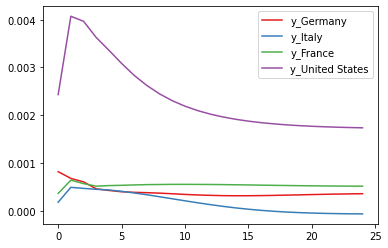

In [148]:
# Define the country and variable of the shock
shock = "r_United States"

# Define the countries and variables that should be in the IRF
country_choice = np.array(['Germany','Italy','France','United States'])
variable_choice = "y"

# Define the length of h
max_h = 24

perform_GIRF(max_h,shock,country_choice,variable_choice, F_l_dict)

# Period Analysis

In [177]:
def quick_perform_GIRF(df_dom_per, df_for_per, max_h,shock,country_choice,variable_choice):
    df_estimates = {}
    resid_dict = {}

    for country in country_list:
        # Define the chosen lag
        lag_x_it = 2
        lag_x_star = 1
        max_lag = max(lag_x_it,lag_x_star)

        x_it_star = pd.concat([df_dom_per[country],df_for_per[country]],axis=1)

        eigenvalues = statsmodels.tsa.vector_ar.vecm.coint_johansen(x_it_star,det_order=-1,k_ar_diff=max_lag-1).eig

        # Determine the rank of cointegration
        rank = np.sum(np.cumsum(eigenvalues) < 1)

        if (rank > k_i[country]):
            rank = k_i[country]

        coin_result = statsmodels.tsa.vector_ar.vecm.VECM(endog= df_dom_per[country][1:],exog=df_for_per[country].diff(1)[1:],exog_coint=df_for_per[country][1:],coint_rank=rank,k_ar_diff=max_lag-1).fit()

        # Initialize a dataframe with the x_star values of lag 0
        df_parameters = pd.concat([df_dom_per[country].shift(1),df_for_per[country].shift(1)], axis=1) @ np.vstack([coin_result.beta,coin_result.det_coef_coint])
        df_parameters.columns = ["_" + str(i) +"_coin" for i in range(coin_result.beta.shape[1])]

        # Initialize a dataframe with the x_star values of lag 0
        lagged_x_star = pd.concat([df_for_per[country]],axis=1)
        lagged_x_star.columns += "_L0"
        df_parameters = pd.concat([df_parameters,lagged_x_star],axis=1)

        # Loop over all lag_x_it values to add the lagged values of x_it to df_parameters
        for lag in range(1,lag_x_it+1):
            if (lag <= lag_x_it-1):
                lagged_x_it = df_dom_per[country].diff(1).shift(lag)
                lagged_x_it.columns += "_dom_diff_L"+str(lag) 
                df_parameters = pd.concat([df_parameters,lagged_x_it], axis=1)

        # Loop over all lag_x_star values to add the lagged values of x_star to df_parameters
        for lag in range(1,lag_x_star+1):
            if (lag <= lag_x_star-1):
                lagged_x_star = df_for_per[country].shift(lag)
                lagged_x_star.columns += "_for_diff_L"+str(lag) 
                df_parameters = pd.concat([df_parameters,lagged_x_star], axis=1)

        # Create and fit the model
        model = VAR(endog = df_dom_per[country].diff(1).iloc[max_lag:], exog = df_parameters.iloc[max_lag:])
        results = model.fit(maxlags=0,trend='ct',method='ols')

        df_estimate =  results.params.T.loc[:,["const","trend"]]

        selected_cols = [col for col in results.params.T.columns if col.endswith("L0")]
        new_df = results.params.T.loc[:,selected_cols]
        new_df.columns = [str(variable) + "_L0" for variable in for_variable_list if set_variables[country][variable]]
        df_estimate = pd.concat([df_estimate,new_df],axis=1)


        selected_cols = [col for col in results.params.T.columns if col.endswith("L1")]
        new_df = results.params.T.loc[:,selected_cols]
        new_df.columns = [str(variable) + "_dom_L2" for variable in dom_variable_list if set_variables[country][variable]]
        df_estimate = pd.concat([df_estimate,-new_df],axis=1)


        selected_cols = [col for col in df_estimate.columns if col.endswith("_L0")]
        A_0 = np.hstack([np.eye(k_i[country]),-df_estimate.loc[:,selected_cols]])

        selected_cols = [col for col in df_estimate.columns if col.endswith("_L2")]
        A_2 = np.hstack([df_estimate.loc[:,selected_cols],np.zeros((k_i[country],k_star[country]))])

        selected_cols = [col for col in results.params.T.columns if col.endswith("coin")] 
        new_df = results.params.T.loc[:,selected_cols] @ np.vstack([coin_result.beta,coin_result.det_coef_coint]).T
        new_df.columns = [str(variable) + "_dom_L1" for variable in dom_variable_list if set_variables[country][variable]] + [str(variable) + "_for_L1" for variable in for_variable_list if set_variables[country][variable]]
        df_estimate = pd.concat([df_estimate,new_df+A_0-A_2],axis=1)

        df_estimates[country] = df_estimate
        resid_dict[country] = results.resid

    # Stack all a_i0 parameters
    matrix_col = []
    for country in country_list:
        matrix_col.append(df_estimates[country].loc[:,"const"])
    a_0 = pd.concat(matrix_col)

    # Stack all a_i1 parameters
    matrix_col = []

    for country in country_list:
        matrix_col.append(df_estimates[country].loc[:,"trend"])
    a_1 = pd.concat(matrix_col)

    # Stack all residuals
    epsilon_t = pd.concat(resid_dict.values(), axis=1).T

    # Calculate the inverse of G_0
    G_0_inv = np.linalg.inv(create_G_j(0,df_estimates))

    # Create a dictionary for the values of F_l
    F_l_dict = {}

    # Fill dictionary by computing the values of F_l 
    for j in range(max_lag+1):
        F_l_dict[j] = G_0_inv @ create_G_j(j,df_estimates)
    
    # Get the index of the country and variable of the shock and define e_j
    e_j = np.zeros((k,1))
    e_j[np.where(dom_variables == shock)[0][0]] = 1
    
    # Compute Sigma
    Sigma = np.cov(epsilon_t)

    # Calculate the GIRF for every h
    girf_matrix = np.hstack([calculate_R_h(h, F_l_dict) @ G_0_inv @ Sigma @ e_j / np.sqrt(e_j.T @ Sigma @ e_j) for h in range(0,max_h+1)])

    for continent in continent_list:
        weighted_GIRF = np.zeros(max_h+1)
        total_weights = 0
        
        continent_country_list = df_continent[continent].index
        for country in continent_country_list:
            if set_variables[country][variable_choice]:
                weighted_GIRF += girf_matrix[np.where(dom_variables == str(variable_choice)+"_"+str(country))[0][0]] * float(df_continent[continent].loc[country])
                total_weights += float(df_continent[continent].loc[country])
        
        weighted_GIRF = weighted_GIRF / total_weights
        
        sns.lineplot(x=np.arange(max_h+1),y=weighted_GIRF,label=continent)
        
    
#     # Initialize an empty array for the index and names of the chosen countries and variables
#     index_array = []
#     name_array = []
    
#     # Loop over all chosen countries and variables and append to arrays
#     for country in country_choice:
#         if set_variables[country][variable_choice]:
#             name_array.append(str(variable_choice)+"_"+str(country))
#         np.where(dom_variables == shock)
        
#         if set_variables[country][variable_choice]:
#             index_array.append(np.where(dom_variables == str(variable_choice)+"_"+str(country))[0][0])
    
#     # Calculate the GIRF for every h
#     girf_matrix = np.hstack([calculate_R_h(h, F_l_dict) @ G_0_inv @ Sigma @ e_j / np.sqrt(e_j.T @ Sigma @ e_j) for h in range(0,max_h+1)])
    
#     # Plot all GIRF in a plot
#     for i in range(len(index_array)):
#         sns.lineplot(x=np.arange(max_h+1),y=girf_matrix[index_array[i]],label=name_array[i])
#     plt.plot()

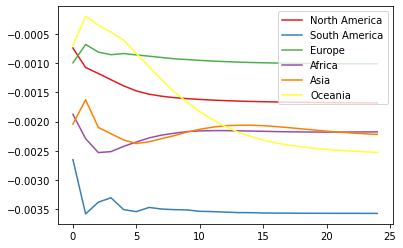

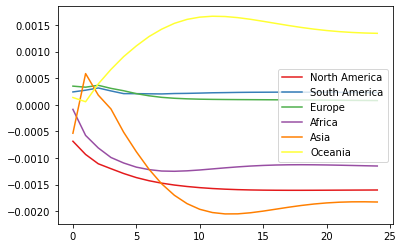

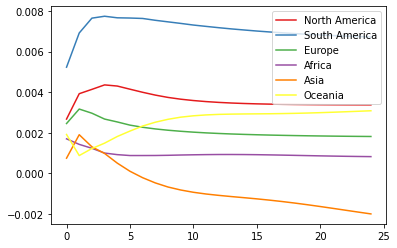

In [181]:
max_h = 24
shock = "r_China"
country_choice = np.array(['Germany','Italy','France','United States'])
variable_choice = "y"

amount_of_periods = 3

periods = len(df_country["Australia"].index)
interval = np.round(np.arange(0,periods+1,periods / amount_of_periods))

for time in range(amount_of_periods):

    df_period = {}
    df_dom_per = {}
    df_for_per = {}

    for country in country_list:
        df_period[country] = df_country[country].iloc[int(interval[int(time)]):int(interval[int(time+1)])]

        domestic_cols = [col for col in df_period[country].columns if not col.endswith("s")]
        df_dom_per[country] = df_period[country].loc[:,domestic_cols]

        foreign_cols = [col for col in df_period[country].columns if col.endswith("s")]
        df_for_per[country] = df_period[country].loc[:,foreign_cols]
        
#     print(df_dom_per["Argentina"])
    quick_perform_GIRF(df_dom_per, df_for_per, max_h,shock,country_choice,variable_choice)
    plt.show()